# properties of each water mass and how they vary

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import gsw

# for anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
def organize(s_t, do_no3, ta_dic, region, final=True):
    # make dictionary of transport and tracer concentrations of each water parcel within a specified region
    
    # the region is based on the boolean input into the function defined here
    # region options are salish, cuc, offshore deep, offshore surface, north, south, fresh, loop
    mydata= s_t
    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4
    saltdiv = 32
    sdiv = 33.5
    if region == 'salish':
        boolean = ((abs(mydata.init_t-mydata.final_t) > 24) & ~np.isnan(mydata.final_section))
    elif region == 'cuc':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv)
    elif region == 'offshore deep':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth > 120)
    elif region == 'offshore surface':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth <=120)
    elif region == 'north':
        boolean = (mydata.final_section==bdy_nor)
    elif region == 'south':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)
    elif region == 'fresh':
        boolean = ((mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv))
    elif region == 'loop':
        boolean = (mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24)
    else:
        print('not in the list of regions, options are: salish, cuc, offshore deep, offshore surface, north, south, fresh, loop')
    


    if final==True: # ie. looking at the water parcels at the outer boundaries
        # get data
        transport = mydata.init_transp[boolean].values
        salt = mydata.init_salt[boolean].values
        temp = mydata.init_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.init_salt[boolean].values
        DO = mydata.init_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.init_salt[boolean].values
        TA = mydata.init_temp[boolean].values
    else: # ie. looking at the water parcels at the JdF boundary
        # get data
        transport = mydata.final_transp[boolean].values
        salt = mydata.final_salt[boolean].values
        temp = mydata.final_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.final_salt[boolean].values
        DO = mydata.final_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.final_salt[boolean].values
        TA = mydata.final_temp[boolean].values

    # set up dictionary
    d = {'transport':transport,'salt':salt,'temp':temp,'DO':DO,'NO3':NO3,'TA':TA,'DIC':DIC}
    df = pd.DataFrame(d)

    return df



def weighted_percentile(data, percentiles, weights=None):
    """
    Compute weighted percentiles.

    Parameters
    ----------
    data : array_like
        Input data (1D array).
    percentiles : float or array_like
        Percentile(s) in range [0, 100].
    weights : array_like, optional
        Weights for each data point. If None, equal weighting is assumed.

    Returns
    -------
    result : float or ndarray
        Weighted percentile(s) of the data.
    """
    data = np.asarray(data)
    if weights is None:
        weights = np.ones_like(data)
    else:
        weights = np.asarray(weights)

    # Ensure 1D inputs
    data = data.ravel()
    weights = weights.ravel()

    # Sort data and weights by data
    sorter = np.argsort(data)
    data_sorted = data[sorter]
    weights_sorted = weights[sorter]

    # Compute cumulative sum of weights
    cum_weights = np.cumsum(weights_sorted)
    cum_weights /= cum_weights[-1]

    # Handle scalar percentile input
    is_scalar = np.isscalar(percentiles)
    percentiles = np.atleast_1d(percentiles)

    # Interpolate
    result = np.interp(percentiles / 100, cum_weights, data_sorted)
    return result[0] if is_scalar else result
        

## isopycnals of each water mass

In [5]:
iso = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/isopycnals.csv')
iso

,Unnamed: 0,transport,section,salt,temp,depth,isopycnal,wm
0,0,2000.389673,3.0,33.762985,6.926159,183.369320,26.333099,offshore deep
1,1,2200.794074,3.0,32.409657,8.598154,17.733801,25.034948,offshore surface
2,2,1745.131644,2.0,34.168667,4.629494,616.098211,26.936357,cuc
3,3,2121.553396,3.0,33.377472,7.233404,123.457073,25.988553,offshore deep
4,4,2320.919398,3.0,33.814331,6.871859,207.385699,26.380944,offshore deep
...,...,...,...,...,...,...,...,...
7084596,7084596,926.580535,2.0,33.924938,6.412238,284.438090,26.529107,cuc
7084597,7084597,20.349378,2.0,28.816675,8.643929,9.057319,22.228724,fresh
7084598,7084598,868.724957,2.0,31.990463,8.343177,20.000496,24.745844,fresh
7084599,7084599,115.814566,2.0,27.492508,9.160521,2.401127,21.124403,fresh


In [6]:
print("CUC - mean: {}, range: {}-{}".format(np.average(iso.isopycnal[iso.wm=='cuc'],weights=iso.transport[iso.wm=='cuc']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='cuc'],25,iso.transport[iso.wm=='cuc']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='cuc'],75,iso.transport[iso.wm=='cuc'])))
print("offshore deep - mean: {}, min: {}, max: {}".format(np.average(iso.isopycnal[iso.wm=='offshore deep'],weights=iso.transport[iso.wm=='offshore deep']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='offshore deep'],25,iso.transport[iso.wm=='offshore deep']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='offshore deep'],75,iso.transport[iso.wm=='offshore deep'])))
print("offshore surface - mean: {}, min: {}, max: {}".format(np.average(iso.isopycnal[iso.wm=='offshore surface'],weights=iso.transport[iso.wm=='offshore surface']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='offshore surface'],25,iso.transport[iso.wm=='offshore surface']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='offshore surface'],75,iso.transport[iso.wm=='offshore surface'])))
print("north - mean: {}, min: {}, max: {}".format(np.average(iso.isopycnal[iso.wm=='north'],weights=iso.transport[iso.wm=='north']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='north'],25,iso.transport[iso.wm=='north']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='north'],75,iso.transport[iso.wm=='north'])))
print("south - mean: {}, min: {}, max: {}".format(np.average(iso.isopycnal[iso.wm=='south'],weights=iso.transport[iso.wm=='south']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='south'],25,iso.transport[iso.wm=='south']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='south'],75,iso.transport[iso.wm=='south'])))
print("fresh - mean: {}, min: {}, max: {}".format(np.average(iso.isopycnal[iso.wm=='fresh'],weights=iso.transport[iso.wm=='fresh']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='fresh'],25,iso.transport[iso.wm=='fresh']),
                                                weighted_percentile(iso.isopycnal[iso.wm=='fresh'],75,iso.transport[iso.wm=='fresh'])))

CUC - mean: 26.470782071019226, range: 26.33540242274134-26.62412152985595
offshore deep - mean: 26.36066939449781, min: 26.1793129033742, max: 26.564155443909456
offshore surface - mean: 25.31697766093574, min: 25.12854319273972, max: 25.661656141931612
north - mean: 25.82876057757791, min: 25.540044510468846, max: 26.22492041730092
south - mean: 25.214600539104264, min: 24.809119088182367, max: 25.708594941378784
fresh - mean: 22.95226268861377, min: 22.33078577890735, max: 23.832887589274645


In [7]:
# total getting in - what's the mean water mass isopycnal?
print("total - mean: {}, min: {}, max: {}".format(np.average(iso.isopycnal,weights=iso.transport),
                                                weighted_percentile(iso.isopycnal,25,iso.transport),
                                                weighted_percentile(iso.isopycnal,75,iso.transport)))

total - mean: 25.740474545957657, min: 25.41869427522339, max: 26.49046292518837


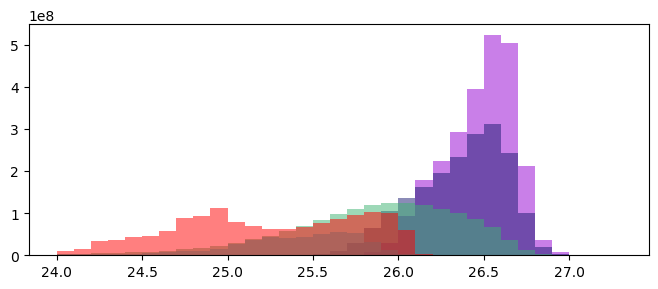

In [8]:
fig, ax = plt.subplots(1,1,figsize=[8,3])
bins = np.arange(24,27.4,0.1)

# cuc
ax.hist(iso.isopycnal[iso.wm=='cuc'],bins=bins,weights=iso.transport[iso.wm=='cuc'],color='darkviolet',alpha=0.5);

# offshore deep
ax.hist(iso.isopycnal[iso.wm=='offshore deep'],bins=bins,weights=iso.transport[iso.wm=='offshore deep'],color='midnightblue',alpha=0.5);

# offshore surface
ax.hist(iso.isopycnal[iso.wm=='offshore surface'],bins=bins,weights=iso.transport[iso.wm=='offshore surface'],color='deepskyblue',alpha=0.5);

# north
ax.hist(iso.isopycnal[iso.wm=='north'],bins=bins,weights=iso.transport[iso.wm=='north'],color='mediumseagreen',alpha=0.5);

# south
ax.hist(iso.isopycnal[iso.wm=='south'],bins=bins,weights=iso.transport[iso.wm=='south'],color='red',alpha=0.5);

## Properties into JdF

In [5]:
region = 'salish'
final = False

up13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20131024/ariane_positions_quantitative.nc'),
             region, final)

up14 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20140903/ariane_positions_quantitative.nc'),
             region, final)

up15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20150905/ariane_positions_quantitative.nc'),
             region, final)

up16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20160913/ariane_positions_quantitative.nc'),
             region, final)

up17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20171012/ariane_positions_quantitative.nc'),
             region, final)

up18 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20180906/ariane_positions_quantitative.nc'),
             region, final)

up19 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20191105/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20191105/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20191105/ariane_positions_quantitative.nc'),
             region, final)

up20 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20201017/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20201017/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20201017/ariane_positions_quantitative.nc'),
             region, final)

up21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20210922/ariane_positions_quantitative.nc'),
             region, final)

up22 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20221015/ariane_positions_quantitative.nc'),
             region, final)

up23 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20230922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20230922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20230922/ariane_positions_quantitative.nc'),
             region, final)

In [6]:
dw13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20140306/ariane_positions_quantitative.nc'),
             region, final)

dw14 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20150212/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20150212/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20150212/ariane_positions_quantitative.nc'),
             region, final)

dw15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20160319/ariane_positions_quantitative.nc'),
             region, final)

dw16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20170419/ariane_positions_quantitative.nc'),
             region, final)

dw17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20180201/ariane_positions_quantitative.nc'),
             region, final)

dw18 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20190406/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20190406/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20190406/ariane_positions_quantitative.nc'),
             region, final)

dw19 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20200127/ariane_positions_quantitative.nc'),
             region, final)

dw20 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20210202/ariane_positions_quantitative.nc'),
             region, final)

dw21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20220125/ariane_positions_quantitative.nc'),
             region, final)

dw22 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20230419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20230419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20230419/ariane_positions_quantitative.nc'),
             region, final)

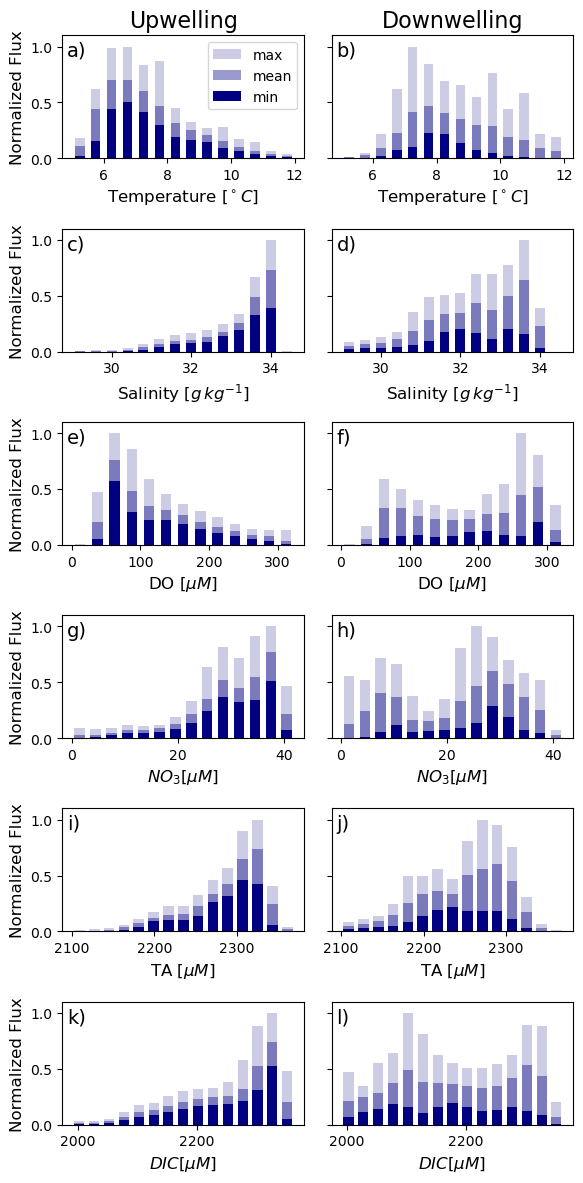

In [7]:
fig, ax = plt.subplots(6, 2, figsize = (6, 12))
plt.rcParams['font.size'] = 12

#TEMPERATURE
bins = np.arange(5,12.5,0.5)
#plt upwelling
h,x,_ = ax[0,0].hist([up13.temp,up14.temp,up15.temp,up16.temp,up17.temp,up18.temp,up19.temp,up20.temp,up21.temp,up22.temp,up23.temp], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,0].set_title('Upwelling', fontsize = 16)
ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[0,0].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,0].set_ylim([0,1.1])
ax[0,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[0,1].hist([dw13.temp,dw14.temp,dw15.temp,dw16.temp,dw17.temp,dw18.temp,dw19.temp,dw20.temp,dw21.temp,dw22.temp], bins=bins,
                             weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,1].set_title('Downwelling', fontsize = 16)
ax[0,1].set_yticklabels([])
ax[0,1].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#SALINITY
bins = np.arange(29,34.8,0.4)
#plt upwelling
h,x,_ = ax[1,0].hist([up13.salt,up14.salt,up15.salt,up16.salt,up17.salt,up18.salt,up19.salt,up20.salt,up21.salt,up22.salt,up23.salt], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,0].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,0].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,0].bar(bin_centers, mini,width = 0.25, color='navy',label='min')

# ax[0].set_title('Winter')
ax[1,0].set_ylabel('Normalized Flux', fontsize=12)
ax[1,0].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[1,1].hist([dw13.salt,dw14.salt,dw15.salt,dw16.salt,dw17.salt,dw18.salt,dw19.salt,dw20.salt,dw21.salt,dw22.salt], bins=bins, 
                           weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,1].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,1].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,1].bar(bin_centers, mini,width = 0.25, color='navy',label='min')


ax[1,1].set_yticklabels([])#,fontsize=14)
ax[1,1].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,1].set_ylim([0,1.1])

#DO
bins = np.arange(0,350,25)
#plt upwelling
h,x,_ = ax[2,0].hist([up13.DO,up14.DO,up15.DO,up16.DO,up17.DO,up18.DO,up19.DO,up20.DO,up21.DO,up22.DO,up23.DO], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,0].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,0].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,0].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[2,0].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[2,1].hist([dw13.DO,dw14.DO,dw15.DO,dw16.DO,dw17.DO,dw18.DO,dw19.DO,dw20.DO,dw21.DO,dw22.DO], bins=bins,
                             weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,1].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,1].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,1].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,1].set_yticklabels([])
ax[2,1].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#NO3
bins = np.arange(0,45,3)
#plt upwelling
h,x,_ = ax[3,0].hist([up13.NO3,up14.NO3,up15.NO3,up16.NO3,up17.NO3,up18.NO3,up19.NO3,up20.NO3,up21.NO3,up22.NO3,up23.NO3], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,0].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,0].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean'),up23.transport
ax[3,0].bar(bin_centers, mini,width = 2, color='navy',label='min')

# ax[0].set_title('Winter')
ax[3,0].set_ylabel('Normalized Flux', fontsize=12)
ax[3,0].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[3,1].hist([dw13.NO3,dw14.NO3,dw15.NO3,dw16.NO3,dw17.NO3,dw18.NO3,dw19.NO3,dw20.NO3,dw21.NO3,dw22.NO3], bins=bins, 
                           weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,1].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,1].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean')
ax[3,1].bar(bin_centers, mini,width = 2, color='navy',label='min')


ax[3,1].set_yticklabels([])#,fontsize=14)
ax[3,1].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,1].set_ylim([0,1.1])

#TA
bins = np.arange(2100,2380,18)
#plt upwelling
h,x,_ = ax[4,0].hist([up13.TA,up14.TA,up15.TA,up16.TA,up17.TA,up18.TA,up19.TA,up20.TA,up21.TA,up22.TA,up23.TA], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,0].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,0].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,0].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[4,0].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[4,1].hist([dw13.TA,dw14.TA,dw15.TA,dw16.TA,dw17.TA,dw18.TA,dw19.TA,dw20.TA,dw21.TA,dw22.TA], bins=bins,
                             weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,1].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,1].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,1].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,1].set_yticklabels([])
ax[4,1].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#DIC
bins = np.arange(1990,2380,25)
#plt upwelling
h,x,_ = ax[5,0].hist([up13.DIC,up14.DIC,up15.DIC,up16.DIC,up17.DIC,up18.DIC,up19.DIC,up20.DIC,up21.DIC,up22.DIC,up23.DIC], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,0].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,0].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,0].bar(bin_centers, mini,width = 17, color='navy',label='min')

ax[5,0].set_ylabel('Normalized Flux', fontsize=12)
ax[5,0].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[5,1].hist([dw13.DIC,dw14.DIC,dw15.DIC,dw16.DIC,dw17.DIC,dw18.DIC,dw19.DIC,dw20.DIC,dw21.DIC,dw22.DIC], bins=bins, 
                           weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,1].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,1].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,1].bar(bin_centers, mini,width = 17, color='navy',label='min')


ax[5,1].set_yticklabels([])#,fontsize=14)
ax[5,1].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,1].set_ylim([0,1.1])

#labels#labels#labels
ax[0,0].text(.02, .8, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=14)
ax[0,1].text(.02, .8, 'b)', ha='left', va='bottom', transform=ax[0,1].transAxes, fontsize=14)
ax[1,0].text(.02, .8, 'c)', ha='left', va='bottom', transform=ax[1,0].transAxes, fontsize=14)
ax[1,1].text(.02, .8, 'd)', ha='left', va='bottom', transform=ax[1,1].transAxes, fontsize=14)
ax[2,0].text(.02, .8, 'e)', ha='left', va='bottom', transform=ax[2,0].transAxes, fontsize=14)
ax[2,1].text(.02, .8, 'f)', ha='left', va='bottom', transform=ax[2,1].transAxes, fontsize=14)
ax[3,0].text(.02, .8, 'g)', ha='left', va='bottom', transform=ax[3,0].transAxes, fontsize=14)
ax[3,1].text(.02, .8, 'h)', ha='left', va='bottom', transform=ax[3,1].transAxes, fontsize=14)
ax[4,0].text(.02, .8, 'i)', ha='left', va='bottom', transform=ax[4,0].transAxes, fontsize=14)
ax[4,1].text(.02, .8, 'j)', ha='left', va='bottom', transform=ax[4,1].transAxes, fontsize=14)
ax[5,0].text(.02, .8, 'k)', ha='left', va='bottom', transform=ax[5,0].transAxes, fontsize=14)
ax[5,1].text(.02, .8, 'l)', ha='left', va='bottom', transform=ax[5,1].transAxes, fontsize=14)

plt.tight_layout()

In [ ]:
# isopycnals getting into the salish sea in the summer, winter, and overall

pd.concat([])

,transport,salt,temp,DO,NO3,TA,DIC
0,303.159669,31.105961,10.294305,268.077454,15.226381,2199.898438,2084.686768
1,248.254126,29.523134,10.287880,278.661102,15.716370,2138.392578,2022.787842
2,55.977753,31.234024,10.248661,264.764465,15.577856,2204.375488,2091.944824
3,130.880503,32.200840,9.578118,251.207657,20.018240,2241.565186,2150.083008
4,175.226405,31.977562,10.253628,270.723083,16.508726,2233.154297,2114.570312
...,...,...,...,...,...,...,...
418700,160.999547,26.220579,8.412736,321.548248,6.863638,1996.107178,1840.528931
418701,20.816615,29.603331,8.680300,309.532013,6.688892,2146.731201,1973.963135
418702,30.645263,27.301222,8.283417,321.553192,7.295625,2044.678467,1884.638550
418703,108.252474,27.604580,8.315922,311.658447,6.918102,2058.526367,1907.849854


## interannual variability

In [3]:
# up13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv')
up19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2019.csv')
up20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2020.csv')
up21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv')
up23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2023.csv')

dw13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv')
dw14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2015.csv')
dw15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv')
dw18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2019.csv')
dw19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv')
dw22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2023.csv')

co14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2014.csv')
co15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2015.csv')
co16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2016.csv')
co17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2017.csv')
co18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2018.csv')
co19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2019.csv')
co20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2020.csv')
co21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2021.csv')
co22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2022.csv')
co23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2023.csv')

In [4]:
upyears = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
downyears = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
allyears = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
properties = ['salt','temp','DO','NO3','[TA-DIC]']

In [5]:
def interannual(region, property, updown):
    if updown == 'up':
        files = [up14, up15, up16, up17, up18, up19, up20, up21, up22, up23]
    elif updown == 'down':
        files = [dw13, dw14, dw15, dw16, dw17, dw18, dw19, dw20, dw21, dw22]
    elif updown == 'both':
        files = [dw13, up14, dw14, up15, dw15, up16, dw16, up17, dw17, up18, dw18, up19, dw19, up20, dw20, up21, dw21, up22, dw22, up23]
    elif updown == 'all':
        files = [co14,co15,co16,co17,co18,co19,co20,co21,co22,co23]

    data = np.zeros(len(files))
    i = 0
    for file in files:
        if property == '[TA-DIC]':
            data[i] = file['TA'][file.regions == region]-file['DIC'][file.regions == region]
        else:
            data[i] = file[property][file.regions == region]
        i+=1

    return data

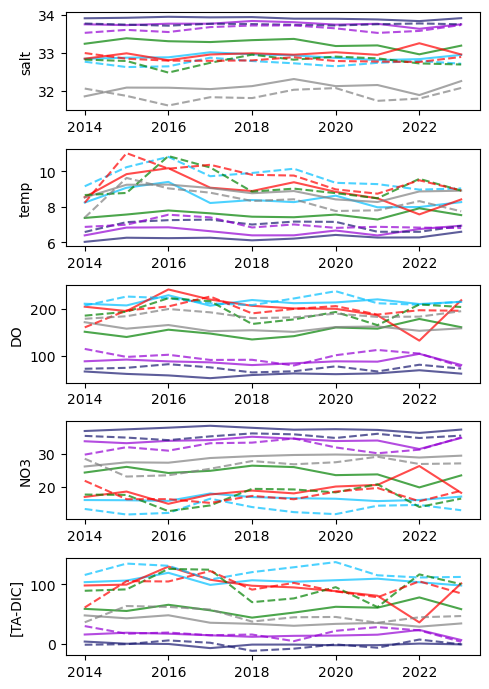

In [6]:
fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].plot(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7)
    ax[i].plot(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7)
    ax[i].plot(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7)
    # ax[i].plot(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7)
    ax[i].plot(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7)
    ax[i].plot(downyears, interannual('cuc', properties[i], 'down'),ls='dashed',c='midnightblue',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore deep', properties[i], 'down'),ls='dashed',c='darkviolet',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore surface', properties[i], 'down'),ls='dashed',c='deepskyblue',alpha=0.7)
    ax[i].plot(downyears, interannual('north', properties[i], 'down'),ls='dashed',c='green',alpha=0.7)
    ax[i].plot(downyears, interannual('south', properties[i], 'down'),ls='dashed',c='red',alpha=0.7)
    # ax[i].plot(downyears, interannual('fresh', properties[i], 'down'),ls='dashed',c='magenta',alpha=0.7)
    ax[i].plot(downyears, interannual('loop', properties[i], 'down'),ls='dashed',c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

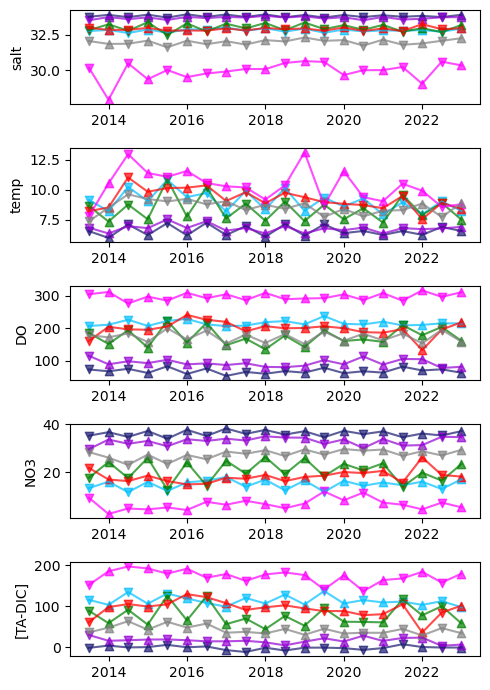

In [7]:
updownyears = np.sort(np.append(np.array(upyears),(np.array(downyears) - 0.5)))
properties = ['salt','temp','DO','NO3','[TA-DIC]']

fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].scatter(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears) - 0.5, interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('fresh', properties[i], 'down'),c='magenta',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.7)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.7)
    ax[i].plot(updownyears, interannual('fresh', properties[i], 'both'),c='magenta',alpha=0.7)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

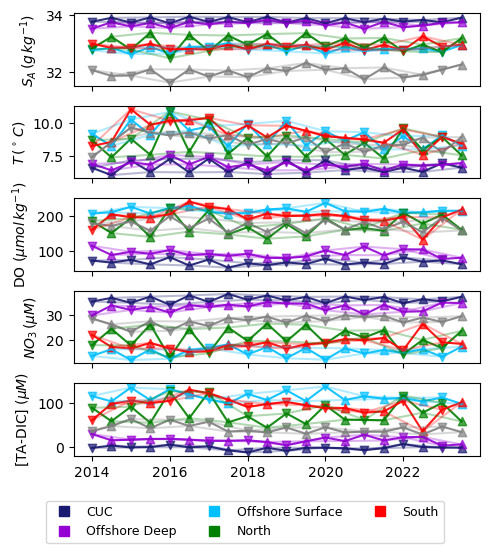

In [8]:
# don't actually keep fresh for final publication... too different from other water masses it makes the y-axis range bad
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','[TA-DIC]']
prop_names = ['$S_A \,(g\, kg^{-1})$','$T \,(^\circ \, C)$','DO $(\mu mol \, kg^{-1})$','$NO_3 \, (\mu M)$','[TA-DIC] $(\mu M)$']

fig, ax = plt.subplots(5,1,figsize=(5,5))

for i in range(len(ax)):

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.9)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.9)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.9)

    ax[i].scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax[i].plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.3)

    ax[i].plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='green',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.3)

    ax[i].set_xticks(upyears[::2])
    ax[i].set_xticklabels([])
    ax[i].set_ylabel(prop_names[i])

ax[4].set_xticklabels(upyears[::2])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South']
colours = ['midnightblue','darkviolet','deepskyblue','green','red']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

plt.tight_layout()
# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')

In [9]:
######################
# BOX PLOT FUNCTIONS #
######################
def box(regions,property,updown,ax,**kwargs):
    tracer = [interannual(region, property, updown) for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ax.set_xticks([])

    return bplot

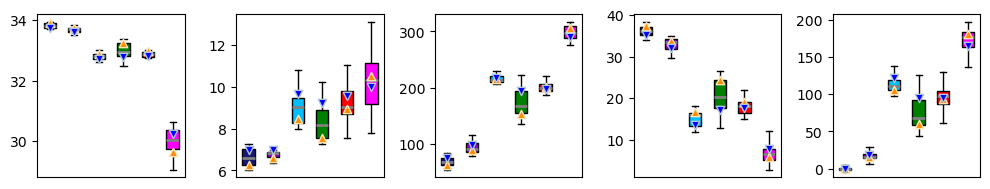

In [10]:
# box plots of the same data
# first using all the already averaged information
colours = ['midnightblue', 'darkviolet', 'deepskyblue', 'green', 'red','magenta']
fig,ax = plt.subplots(1,5,figsize=(10,2))

regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'fresh']
for i in range(len(ax)):
    bplot = box(regions,properties[i],'both',ax[i],alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax[i].scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='darkorange',edgecolors='moccasin',zorder=4)
    ax[i].scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='blue',edgecolors='lightsteelblue',zorder=4)


    # add upwelling and downwelling means

plt.tight_layout()

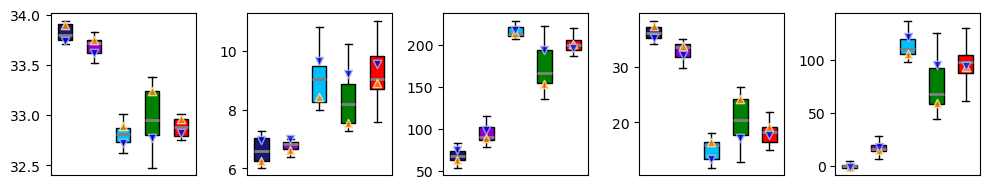

In [11]:
colours = ['midnightblue', 'darkviolet', 'deepskyblue', 'green', 'red']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south']
fig,ax = plt.subplots(1,5,figsize=(10,2))
for i in range(len(ax)):
    bplot = box(regions,properties[i],'both',ax[i],alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax[i].scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='darkorange',edgecolors='moccasin',zorder=4,alpha=0.8)
    ax[i].scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='blue',edgecolors='lightsteelblue',zorder=4,alpha=0.8)


    # add upwelling and downwelling means

plt.tight_layout()

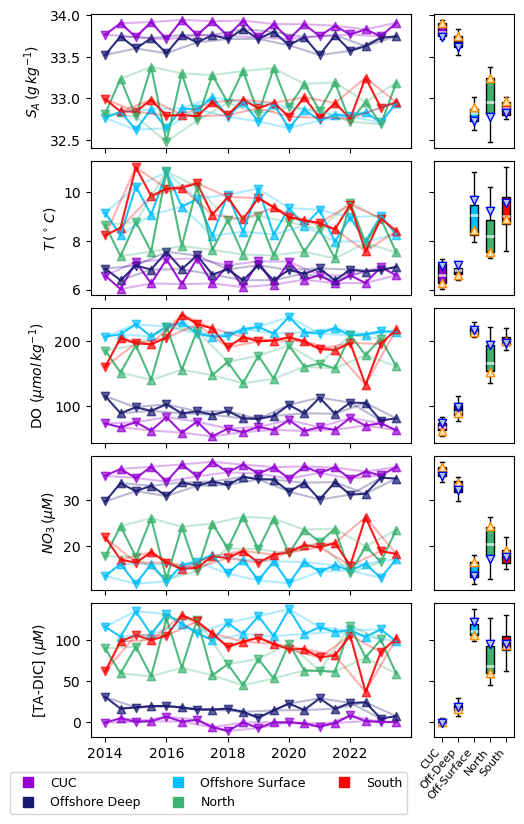

In [12]:
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','[TA-DIC]']
prop_names = ['$S_A \,(g\, kg^{-1})$','$T \,(^\circ \, C)$','DO $(\mu mol \, kg^{-1})$','$NO_3 \, (\mu M)$','[TA-DIC] $(\mu M)$']

fig = plt.figure(constrained_layout=True, figsize=[5,2*4])
gs = GridSpec(5, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])

# TIMESERIES
i=0
for ax in [ax1,ax3,ax5,ax7,ax9]:

    ax.plot(updownyears, interannual('cuc', properties[i], 'both'),c='darkviolet',alpha=0.9)
    ax.plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='midnightblue',alpha=0.9)
    ax.plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.9)
    ax.plot(updownyears, interannual('north', properties[i], 'both'),c='mediumseagreen',alpha=0.9)
    ax.plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.9)
    # ax.plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.9)

    ax.scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    # ax.scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax.scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    # ax.scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax.plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.3)
    # ax.plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.3)

    ax.plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.3)
    # ax.plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.3)

    ax.set_xticks(upyears[::2])
    ax.set_xticklabels([])
    ax.set_ylabel(prop_names[i])
    i+=1

ax9.set_xticklabels(upyears[::2])

# BOXPLOTS
colours = ['darkviolet', 'midnightblue', 'deepskyblue', 'mediumseagreen', 'red']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south']
i=0
for ax in [ax2,ax4,ax6,ax8,ax10]:
    bplot = box(regions,properties[i],'both',ax,alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax.scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='moccasin',edgecolors='darkorange',zorder=4)
    ax.scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)
    ax.set_yticks([])
    i+=1
ax10.set_xticks(np.arange(1,len(regions)+1))
ax10.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'North', 'South'],rotation=50,ha='right',fontsize=8)

# ensure that the box plots share the same yaxis as the timeseries plots
ax2.sharey(ax1)
ax2.tick_params(axis='y', which='both', labelleft=False)
ax4.sharey(ax3)
ax4.tick_params(axis='y', which='both', labelleft=False)
ax6.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax8.sharey(ax7)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax10.sharey(ax9)
ax10.tick_params(axis='y', which='both', labelleft=False)

# # build legend handles    
legend_handles = []
regionnames = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regionnames[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.38, 0.05), frameon=True,fontsize=9)

# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')

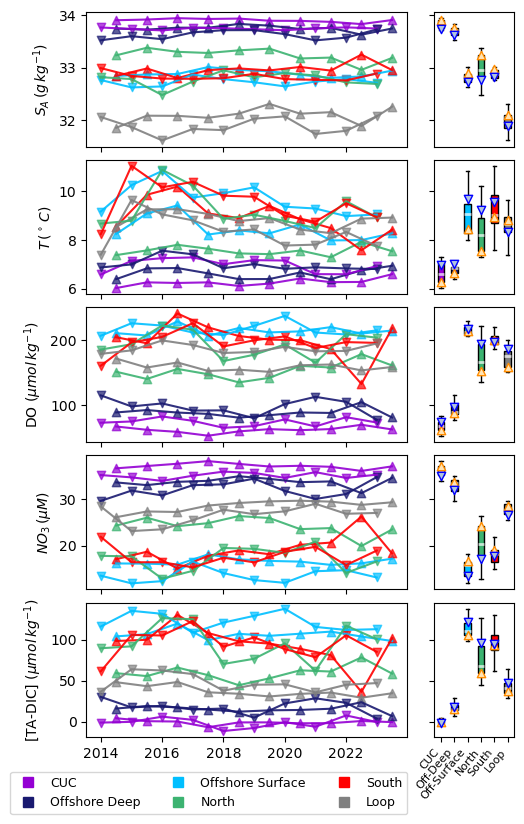

In [13]:
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','[TA-DIC]']
prop_names = ['$S_A \,(g\, kg^{-1})$','$T \,(^\circ \, C)$','DO $(\mu mol \, kg^{-1})$','$NO_3 \, (\mu M)$','[TA-DIC] $(\mu mol \, kg^{-1})$']

fig = plt.figure(constrained_layout=True, figsize=[5,2*4])
gs = GridSpec(5, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])

# TIMESERIES
i=0
for ax in [ax1,ax3,ax5,ax7,ax9]:

    ax.scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax.scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax.plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.9)
    ax.plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.9)
    ax.plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.9)
    ax.plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.9)
    ax.plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.9)
    ax.plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.9)

    ax.plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.9)
    ax.plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.9)
    ax.plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.9)
    ax.plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.9)
    ax.plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.9)
    ax.plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.9)

    ax.set_xticks(upyears[::2])
    ax.set_xticklabels([])
    ax.set_ylabel(prop_names[i])
    i+=1

ax9.set_xticklabels(upyears[::2])

# BOXPLOTS
colours = ['darkviolet', 'midnightblue', 'deepskyblue', 'mediumseagreen', 'red','grey']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'loop']
i=0
for ax in [ax2,ax4,ax6,ax8,ax10]:
    bplot = box(regions,properties[i],'both',ax,alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax.scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='moccasin',edgecolors='darkorange',zorder=4)
    ax.scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)
    ax.set_yticks([])
    i+=1
ax10.set_xticks(np.arange(1,len(regions)+1))
ax10.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'North', 'South','Loop'],rotation=50,ha='right',fontsize=8)

# ensure that the box plots share the same yaxis as the timeseries plots
ax2.sharey(ax1)
ax2.tick_params(axis='y', which='both', labelleft=False)
ax4.sharey(ax3)
ax4.tick_params(axis='y', which='both', labelleft=False)
ax6.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax8.sharey(ax7)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax10.sharey(ax9)
ax10.tick_params(axis='y', which='both', labelleft=False)

# # build legend handles    
legend_handles = []
regionnames = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South','Loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','grey']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regionnames[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.38, 0.05), frameon=True,fontsize=9)

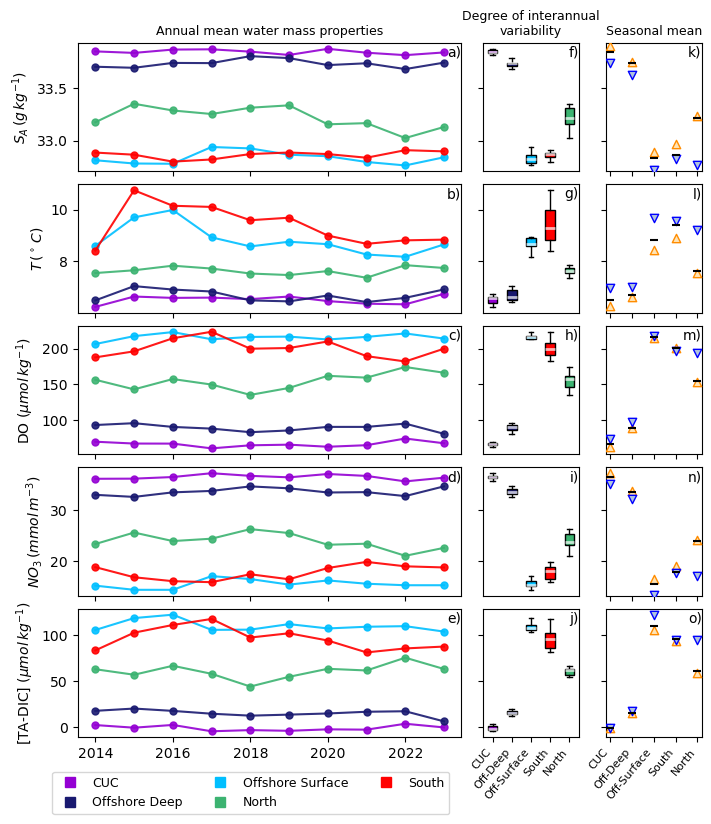

In [14]:
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','[TA-DIC]']
prop_names = ['$S_A \,(g\, kg^{-1})$','$T \,(^\circ \, C)$','DO $(\mu mol \, kg^{-1})$','$NO_3 \, (mmol\,m^{-3})$','[TA-DIC] $(\mu mol \, kg^{-1})$']

fig = plt.figure(constrained_layout=True, figsize=[7,2*4])
gs = GridSpec(5, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
axa = fig.add_subplot(gs[0, 5])

ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
axb = fig.add_subplot(gs[1, 5])

ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
axc = fig.add_subplot(gs[2, 5])

ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
axd = fig.add_subplot(gs[3, 5])

ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
axe = fig.add_subplot(gs[4, 5])

# TIMESERIES
i=0
for ax in [ax1,ax3,ax5,ax7,ax9]:

    ax.plot(allyears, interannual('cuc', properties[i], 'all'),c='darkviolet',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('offshore deep', properties[i], 'all'),c='midnightblue',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('offshore surface', properties[i], 'all'),c='deepskyblue',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('north', properties[i], 'all'),c='mediumseagreen',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('south', properties[i], 'all'),c='red',marker='o',markersize=5,alpha=0.9)
    # ax.plot(allyears, interannual('loop', properties[i], 'all'),c='grey',marker='o',markersize=5,alpha=0.9)

    ax.set_xticks(upyears[::2])
    ax.set_xticklabels([])
    ax.set_ylabel(prop_names[i])
    i+=1

ax9.set_xticklabels(upyears[::2])

# BOXPLOTS
colours = ['darkviolet', 'midnightblue', 'deepskyblue', 'red', 'mediumseagreen', ]
regions = ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']
i=0
for ax in [ax2,ax4,ax6,ax8,ax10]:
    bplot = box(regions,properties[i],'all',ax,alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    ax.set_yticks([])
    i+=1
ax10.set_xticks(np.arange(1,len(regions)+1))
ax10.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'South',  'North'],rotation=50,ha='right',fontsize=8)

i=0
for ax in [axa,axb,axc,axd,axe]:
    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    allmean =  [np.nanmean(interannual(region, properties[i], 'all')) for region in regions]

    ax.scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='moccasin',edgecolors='darkorange',zorder=4)
    ax.scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)
    ax.scatter(np.arange(1,len(regions)+1),allmean, marker='_',c='k',zorder=4)

    ax.set_yticks([])
    ax.set_xticks(np.arange(1,len(regions)+1))
    ax.set_xticklabels([])
    i+=1
axe.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'South', 'North'],rotation=50,ha='right',fontsize=8)

# ensure that the box plots share the same yaxis as the timeseries plots
ax2.sharey(ax1)
ax2.tick_params(axis='y', which='both', labelleft=False)
ax4.sharey(ax3)
ax4.tick_params(axis='y', which='both', labelleft=False)
ax6.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax8.sharey(ax7)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax10.sharey(ax9)
ax10.tick_params(axis='y', which='both', labelleft=False)
axa.sharey(ax1)
axa.tick_params(axis='y', which='both', labelleft=False)
axb.sharey(ax3)
axb.tick_params(axis='y', which='both', labelleft=False)
axc.sharey(ax5)
axc.tick_params(axis='y', which='both', labelleft=False)
axd.sharey(ax7)
axd.tick_params(axis='y', which='both', labelleft=False)
axe.sharey(ax9)
axe.tick_params(axis='y', which='both', labelleft=False)


# # build legend handles    
legend_handles = []
regionnames = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regionnames[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.35, 0.05), frameon=True,fontsize=9)

ax1.set_title('Annual mean water mass properties',fontsize=9)
ax2.set_title('Degree of interannual\nvariability',fontsize=9)
axa.set_title('Seasonal mean',fontsize=9)


# add text to each figure
ax1.text(1,.98,'a)', ha='right', va='top', transform=ax1.transAxes,fontsize=10)
ax2.text(1,.98,'f)', ha='right', va='top', transform=ax2.transAxes,fontsize=10)
axa.text(1,.98,'k)', ha='right', va='top', transform=axa.transAxes,fontsize=10)

ax3.text(1,.98,'b)', ha='right', va='top', transform=ax3.transAxes,fontsize=10)
ax4.text(1,.98,'g)', ha='right', va='top', transform=ax4.transAxes,fontsize=10)
axb.text(1,.98,'l)', ha='right', va='top', transform=axb.transAxes,fontsize=10)

ax5.text(1,.98,'c)', ha='right', va='top', transform=ax5.transAxes,fontsize=10)
ax6.text(1,.98,'h)', ha='right', va='top', transform=ax6.transAxes,fontsize=10)
axc.text(1,.98,'m)', ha='right', va='top', transform=axc.transAxes,fontsize=10)

ax7.text(1,.98,'d)', ha='right', va='top', transform=ax7.transAxes,fontsize=10)
ax8.text(1,.98,'i)', ha='right', va='top', transform=ax8.transAxes,fontsize=10)
axd.text(1,.98,'n)', ha='right', va='top', transform=axd.transAxes,fontsize=10)

ax9.text(1,.98,'e)', ha='right', va='top', transform=ax9.transAxes,fontsize=10)
ax10.text(1,.98,'j)', ha='right', va='top', transform=ax10.transAxes,fontsize=10)
axe.text(1,.98,'o)', ha='right', va='top', transform=axe.transAxes,fontsize=10)

plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')

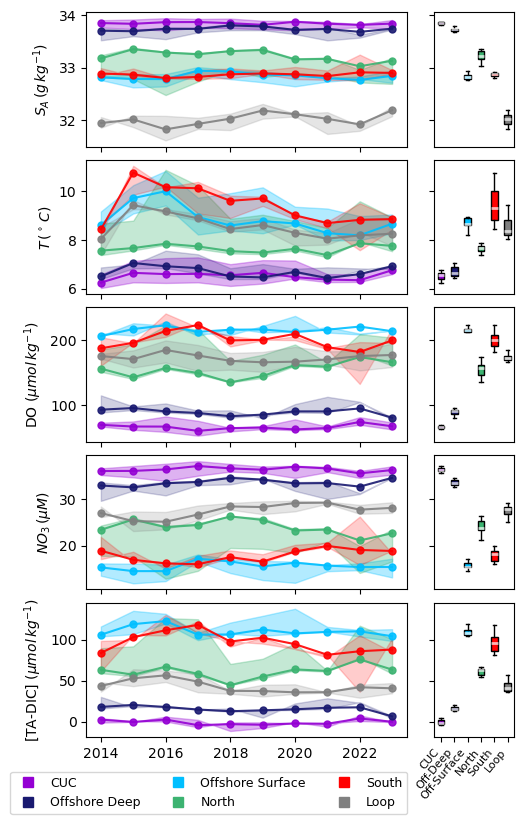

In [15]:
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','[TA-DIC]']
prop_names = ['$S_A \,(g\, kg^{-1})$','$T \,(^\circ \, C)$','DO $(\mu mol \, kg^{-1})$','$NO_3 \, (\mu M)$','[TA-DIC] $(\mu mol \, kg^{-1})$']

fig = plt.figure(constrained_layout=True, figsize=[5,2*4])
gs = GridSpec(5, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])

# TIMESERIES
i=0
for ax in [ax1,ax3,ax5,ax7,ax9]:

    ax.plot(allyears, interannual('cuc', properties[i], 'all'),c='darkviolet',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('offshore deep', properties[i], 'all'),c='midnightblue',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('offshore surface', properties[i], 'all'),c='deepskyblue',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('north', properties[i], 'all'),c='mediumseagreen',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('south', properties[i], 'all'),c='red',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('loop', properties[i], 'all'),c='grey',marker='o',markersize=5,alpha=0.9)

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax.fill_between(upyears,interannual('cuc', properties[i], 'up'),interannual('cuc', properties[i], 'down'),color='darkviolet',alpha=0.3)
    ax.fill_between(upyears,interannual('offshore deep', properties[i], 'up'),interannual('offshore deep', properties[i], 'down'),color='midnightblue',alpha=0.2)
    ax.fill_between(upyears,interannual('offshore surface', properties[i], 'up'),interannual('offshore surface', properties[i], 'down'),color='deepskyblue',alpha=0.3)
    ax.fill_between(upyears,interannual('north', properties[i], 'up'),interannual('north', properties[i], 'down'),color='mediumseagreen',alpha=0.3)
    ax.fill_between(upyears,interannual('south', properties[i], 'up'),interannual('south', properties[i], 'down'),color='red',alpha=0.2)
    ax.fill_between(upyears,interannual('loop', properties[i], 'up'),interannual('loop', properties[i], 'down'),color='grey',alpha=0.2)

    ax.set_xticks(upyears[::2])
    ax.set_xticklabels([])
    ax.set_ylabel(prop_names[i])
    i+=1

ax9.set_xticklabels(upyears[::2])

# BOXPLOTS
colours = ['darkviolet', 'midnightblue', 'deepskyblue', 'mediumseagreen', 'red','grey']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'loop']
i=0
for ax in [ax2,ax4,ax6,ax8,ax10]:
    bplot = box(regions,properties[i],'all',ax,alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    # upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    # dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    # ax.scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='moccasin',edgecolors='darkorange',zorder=4)
    # ax.scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)
    ax.set_yticks([])
    i+=1
ax10.set_xticks(np.arange(1,len(regions)+1))
ax10.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'North', 'South','Loop'],rotation=50,ha='right',fontsize=8)

# ensure that the box plots share the same yaxis as the timeseries plots
ax2.sharey(ax1)
ax2.tick_params(axis='y', which='both', labelleft=False)
ax4.sharey(ax3)
ax4.tick_params(axis='y', which='both', labelleft=False)
ax6.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax8.sharey(ax7)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax10.sharey(ax9)
ax10.tick_params(axis='y', which='both', labelleft=False)

# # build legend handles    
legend_handles = []
regionnames = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South','Loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','grey']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regionnames[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.38, 0.05), frameon=True,fontsize=9)

In [16]:
prop='salt'
d = {'cuc': interannual('cuc', prop, 'both'),
         'offshore deep': interannual('offshore deep', prop, 'both'),
         'offshore surface':interannual('offshore surface', prop, 'both'),
         'north':interannual('north', prop, 'both'),
         'south':interannual('south', prop, 'both'),
         'loop':interannual('loop', prop, 'both'),
         'fresh':interannual('fresh', prop, 'both'),}
mydata = pd.DataFrame(d)

np.mean(mydata['cuc']) - np.mean(mydata['north'])

0.8173878650431234

In [17]:
# statistics of combined periods
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'both'),
         'offshore deep': interannual('offshore deep', prop, 'both'),
         'offshore surface': interannual('offshore surface', prop, 'both'),
         'north': interannual('north', prop, 'both'),
         'south': interannual('south', prop, 'both'),
         'loop': interannual('loop', prop, 'both'),
         'fresh': interannual('fresh', prop, 'both')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.8821    True   8.447731
1                cuc              loop   -1.8359    True  12.963691
2                cuc             north   -0.8174    True   4.081786
3                cuc     offshore deep   -0.1368   False   1.516836
4                cuc  offshore surface   -1.0142    True  10.276317
5                cuc             south   -0.9263    True   8.896983
6              fresh              loop    2.0461    True  -4.324937
7              fresh             north    3.0647    True  -6.205970
8              fresh     offshore deep    3.7453    True  -8.136259
9              fresh  offshore surface    2.8679    True  -6.206686
10             fresh             south    2.9558    True  -6.380471
11              loop             north    1.0186    True  -4.43

In [18]:
# statistics of upwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'up'),
         'offshore deep': interannual('offshore deep', prop, 'up'),
         'offshore surface': interannual('offshore surface', prop, 'up'),
         'north': interannual('north', prop, 'up'),
         'south': interannual('south', prop, 'up'),
         'loop': interannual('loop', prop, 'up'),
         'fresh': interannual('fresh', prop, 'up')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -4.2623    True   7.823969
1                cuc              loop   -1.8141    True  17.650334
2                cuc             north   -0.6636    True   7.337954
3                cuc     offshore deep   -0.1528   False   3.434066
4                cuc  offshore surface   -1.0107    True  19.629195
5                cuc             south   -0.9366    True  10.757573
6              fresh              loop    2.4482    True  -4.424049
7              fresh             north    3.5987    True  -6.528460
8              fresh     offshore deep    4.1095    True  -7.532416
9              fresh  offshore surface    3.2516    True  -5.953287
10             fresh             south    3.3257    True  -6.039186
11              loop             north    1.1505    True  -8.66

In [19]:
# statistics of downwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'down'),
         'offshore deep': interannual('offshore deep', prop, 'down'),
         'offshore surface': interannual('offshore surface', prop, 'down'),
         'north': interannual('north', prop, 'down'),
         'south': interannual('south', prop, 'down'),
         'loop': interannual('loop', prop, 'down'),
         'fresh': interannual('fresh', prop, 'down')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.5018    True  17.161765
1                cuc              loop   -1.8578    True  16.140729
2                cuc             north   -0.9711    True  10.328172
3                cuc     offshore deep   -0.1207   False   2.009234
4                cuc  offshore surface   -1.0177    True  18.133725
5                cuc             south   -0.9160    True  17.048992
6              fresh              loop    1.6440    True  -7.044070
7              fresh             north    2.5307    True -11.310243
8              fresh     offshore deep    3.3811    True -15.967829
9              fresh  offshore surface    2.4842    True -11.792873
10             fresh             south    2.5859    True -12.312262
11              loop             north    0.8867    True  -6.02

In [20]:
# salt
property = 'salt'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


salt
cuc
UP: mean =33.90180105325061, std =0.031570397421275494, CV = 0.0009312306851098233
DOWN: mean =33.742329939150835, std =0.01925783105913458, CV = 0.0005707321069369884
UP & DOWN: mean =33.82206549620072, std =0.08391386109145195, CV = 0.0024810389271133692


offshore deep
UP: mean =33.74899749163611, std =0.05066737181205116, CV = 0.0015013000556418857
DOWN: mean =33.62158210610325, std =0.07829421849317163, CV = 0.0023286892998101677
UP & DOWN: mean =33.685289798869675, std =0.0916910776767344, CV = 0.002721991653454949


offshore surface
UP: mean =32.8911234277561, std =0.06144287080432874, CV = 0.0018680684756568226
DOWN: mean =32.72466233562168, std =0.07278864636623576, CV = 0.002224274940401856
UP & DOWN: mean =32.80789288168889, std =0.10707021296746885, CV = 0.003263550431403294


north
UP: mean =33.23816381492201, std =0.11715755664884789, CV = 0.003524790277261072
DOWN: mean =32.77119144739318, std =0.12467337044507416, CV = 0.0038043587962070095
UP & DOWN: mean =33.

In [21]:
# temp
property = 'temp'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


temp
cuc
UP: mean =6.259874243842211, std =0.14705393953537493, CV = 0.023491516571603772
DOWN: mean =6.963554962353487, std =0.26728145496379985, CV = 0.03838290304431893
UP & DOWN: mean =6.611714603097849, std =0.4127029889052857, CV = 0.06241996421199397


offshore deep
UP: mean =6.616533837230229, std =0.20584802893497509, CV = 0.031111157896102574
DOWN: mean =6.993844204147978, std =0.2521137365087213, CV = 0.036047948617327685
UP & DOWN: mean =6.805189020689103, std =0.29758721716885456, CV = 0.04372945648741443


offshore surface
UP: mean =8.44081948966184, std =0.4415623867425109, CV = 0.05231273898030024
DOWN: mean =9.660364021721131, std =0.5775201994575896, CV = 0.05978244693047252
UP & DOWN: mean =9.050591755691487, std =0.797543527026938, CV = 0.08812059460370653


north
UP: mean =7.548265960170317, std =0.18277297465931625, CV = 0.024213902321903905
DOWN: mean =9.212934247420101, std =0.7304190142318221, CV = 0.07928190895711228
UP & DOWN: mean =8.38060010379521, std =0.9

In [22]:
# DO
property = 'DO'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


DO
cuc
UP: mean =62.26294479785297, std =4.330244411524532, CV = 0.06954769687786841
DOWN: mean =74.11431934265603, std =5.628583084771944, CV = 0.07594461009280899
UP & DOWN: mean =68.1886320702545, std =7.767222911257389, CV = 0.11390788574926752


offshore deep
UP: mean =88.59546762660214, std =6.410299272530984, CV = 0.0723547089287691
DOWN: mean =97.83605936545464, std =11.926900679239026, CV = 0.12190700194380832
UP & DOWN: mean =93.21576349602842, std =10.631019810392555, CV = 0.11404744660859324


offshore surface
UP: mean =214.56251958578895, std =6.39342225264376, CV = 0.029797479377974334
DOWN: mean =217.29023315155123, std =9.299421588040342, CV = 0.04279723691747511
UP & DOWN: mean =215.9263763686701, std =8.095532737909622, CV = 0.03749209741790603


north
UP: mean =153.25578340683757, std =12.017018440511588, CV = 0.07841151683399013
DOWN: mean =193.80714920240513, std =18.668513223958552, CV = 0.0963252042083434
UP & DOWN: mean =173.53146630462135, std =25.6430180764245

In [23]:
# NO3
property = 'NO3'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


NO3
cuc
UP: mean =37.274649850850615, std =0.5496543266338779, CV = 0.014746062775458499
DOWN: mean =35.175854974763894, std =0.6073500905656434, CV = 0.01726610741946067
UP & DOWN: mean =36.22525241280725, std =1.1986375551519657, CV = 0.03308845281442935


offshore deep
UP: mean =33.79437810110643, std =0.9610393649998391, CV = 0.028437847328469542
DOWN: mean =32.141572223778574, std =1.6732761346068834, CV = 0.0520595608378168
UP & DOWN: mean =32.96797516244251, std =1.5952011343070516, CV = 0.04838638486127965


offshore surface
UP: mean =16.54439576357002, std =0.67404805171861, CV = 0.040741775121387755
DOWN: mean =13.468247863391198, std =1.4029566328592065, CV = 0.10416771706976538
UP & DOWN: mean =15.00632181348061, std =1.8912920241988784, CV = 0.12603301779786413


north
UP: mean =24.258695111522997, std =1.7698497514627907, CV = 0.07295733522872397
DOWN: mean =17.13979517485194, std =2.4829093519105125, CV = 0.14486225340390982
UP & DOWN: mean =20.69924514318747, std =4.161

In [24]:
# TA-DIC
property = '[TA-DIC]'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


[TA-DIC]
cuc
UP: mean =-0.7551851471120699, std =2.620574273019167, CV = -3.4701083344138817
DOWN: mean =-1.2186445940239536, std =5.6152321121360895, CV = -4.607768450024173
UP & DOWN: mean =-0.9869148705680117, std =4.387803466601496, CV = -4.445979686248042


offshore deep
UP: mean =15.328718370351407, std =4.188423558974706, CV = 0.2732402969237073
DOWN: mean =17.959239624933662, std =8.313498319912755, CV = 0.46290925972003466
UP & DOWN: mean =16.643978997642535, std =6.71256162951116, CV = 0.40330269765792975


offshore surface
UP: mean =105.9736696985743, std =5.637571123425053, CV = 0.05319784753571572
DOWN: mean =121.76884080987966, std =10.042372591136353, CV = 0.08247079075685484
UP & DOWN: mean =113.87125525422698, std =11.344055065288389, CV = 0.09962176178669366


north
UP: mean =59.45912176566262, std =8.386782402589072, CV = 0.14105123240202988
DOWN: mean =95.38040213143549, std =21.078745963882167, CV = 0.22099661453340666
UP & DOWN: mean =77.41976194854905, std =24.08